In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asap-aes/valid_sample_submission_1_column.csv
/kaggle/input/asap-aes/Training_Materials.zip
/kaggle/input/asap-aes/training_set_rel3.xls
/kaggle/input/asap-aes/valid_sample_submission_1_column_no_header.csv
/kaggle/input/asap-aes/Essay_Set_Descriptions.zip
/kaggle/input/asap-aes/training_set_rel3.xlsx
/kaggle/input/asap-aes/valid_set.xls
/kaggle/input/asap-aes/training_set_rel3.tsv
/kaggle/input/asap-aes/valid_sample_submission_5_column.csv
/kaggle/input/asap-aes/valid_set.xlsx
/kaggle/input/asap-aes/valid_set.tsv
/kaggle/input/asap-aes/test_set.tsv
/kaggle/input/asap-aes/valid_sample_submission_2_column.csv


In [1]:
import os
import pandas as pd

df = pd.read_csv("../input/asap-aes/training_set_rel3.tsv", sep='\t', encoding='ISO-8859-1')
df = df.dropna(axis=1)
df = df.drop(columns=['rater1_domain1', 'rater2_domain1'])
df = df.drop(columns=['essay_id', 'essay_set'])
df.head()

,essay,domain1_score
0,"Dear local newspaper, I think effects computer...",8
1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,"Dear @LOCATION1, I know having computers has a...",8


In [2]:
df['essay'][1]

"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a @NUM1 page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer will help us in life by talking or making friends on line. Many people have myspace, facebooks, aim, these all benefit us by having conversations with one another. Many people believe computers are bad but how can you make friends if you can never talk to them? I am very fortunate for having a computer that can help with not only school work but my social life and how I make friends. Computers help us with finding our locations, coordibates and millions of information online. If we didn't go on the i

In [3]:
import warnings
warnings.filterwarnings("ignore")                     #Ignoring unnecessory warnings

import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import nltk                                         #Natural language processing tool-kit

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from gensim.models import Word2Vec                                   #For Word2Vec

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [4]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

In [5]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy','mae'])
    model.summary()

    return model

In [7]:
X=df
y = X['domain1_score']

In [9]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

cv = KFold(n_splits = 5, shuffle = True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    
    train_essays = X_train['essay']
    test_essays = X_test['essay']
    
    sentences = []
    
    for essay in train_essays:
            # Obtaining all sentences from the training essays.
            sentences += essay_to_sentences(essay, remove_stopwords = True)
            
    # Initializing variables for word2vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

    clean_train_essays = []
    
    # Generate training and testing data word vectors.
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    
    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    
    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    
    lstm_model = get_model()
    lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=2)
    #lstm_model.load_weights('./model_weights/final_lstm.h5')
    y_pred = lstm_model.predict(testDataVecs)
    
    # Save any one of the 5 models.
    if count == 5:
         lstm_model.save('./model_weights/final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)

    count += 1



--------Fold 1--------

Training Word2Vec Model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            721200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
163/163 [==============================] - 2s 14ms/step - loss: 64.1702 - accuracy: 0.1120 - mae: 4.3562
Epoch 2/2
163/163 [==============================] - 2s 13ms/step - loss: 40.5542

OSError: Unable to create file (unable to open file: name = './model_weights/final_lstm.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   essay          12976 non-null  object
 1   domain1_score  12976 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 202.9+ KB


In [10]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))

Average Kappa score after a 5-fold cross validation:  0.9098


In [11]:
demo = ["Dear@CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a @NUM1 page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer will help us in life by talking or making friends on line. Many people have myspace, facebooks, aim, these all benefit us by having conversations with one another. Many people believe computers are bad but how can you make friends if you can never talk to them? I am very fortunate for having a computer that can help with not only school work but my social life and how I make friends. Computers help us with finding our locations, coordibates and millions of information online. If we didn't go on the internet a lot we wouldn't know how to go onto websites that @MONTH1 help us with locations and coordinates like @LOCATION1. Would you rather use a computer or be in @LOCATION3. When your supposed to be vacationing in @LOCATION2. Million of information is found on the internet. You can as almost every question and a computer will have it. Would you rather easily draw up a house plan on the computers or take @NUM1 hours doing one by hand with ugly erazer marks all over it, you are garrenteed that to find a job with a drawing like that. Also when appling for a job many workers must write very long papers like a @NUM3 word essay on why this job fits you the most, and many people I know don't like writing @NUM3 words non-stopp for hours when it could take them I hav an a computer. That is why computers we needed a lot now adays. I hope this essay has impacted your descion on computers because they are great machines to work with. The other day I showed my mom how to use a computer and she said it was the greatest invention sense sliced bread! Now go out and buy a computer to help you chat online with friends, find locations and millions of information on one click of the button and help your self with getting a job with neat, prepared, printed work that your boss will love."]
demo_df = pd.DataFrame(demo,columns=['essay'])
demo_df.head()

,essay
0,"Dear@CAPS1 @CAPS2, I believe that using comput..."


In [12]:
type(demo_df['essay'])

pandas.core.series.Series

In [13]:
content = "Dear@CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a @NUM1 page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer will help us in life by talking or making friends on line. Many people have myspace, facebooks, aim, these all benefit us by having conversations with one another. Many people believe computers are bad but how can you make friends if you can never talk to them? I am very fortunate for having a computer that can help with not only school work but my social life and how I make friends. Computers help us with finding our locations, coordibates and millions of information online. If we didn't go on the internet a lot we wouldn't know how to go onto websites that @MONTH1 help us with locations and coordinates like @LOCATION1. Would you rather use a computer or be in @LOCATION3. When your supposed to be vacationing in @LOCATION2. Million of information is found on the internet. You can as almost every question and a computer will have it. Would you rather easily draw up a house plan on the computers or take @NUM1 hours doing one by hand with ugly erazer marks all over it, you are garrenteed that to find a job with a drawing like that. Also when appling for a job many workers must write very long papers like a @NUM3 word essay on why this job fits you the most, and many people I know don't like writing @NUM3 words non-stopp for hours when it could take them I hav an a computer. That is why computers we needed a lot now adays. I hope this essay has impacted your descion on computers because they are great machines to work with. The other day I showed my mom how to use a computer and she said it was the greatest invention sense sliced bread! Now go out and buy a computer to help you chat online with friends, find locations and millions of information on one click of the button and help your self with getting a job with neat, prepared, printed work that your boss will love."

In [14]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
num_features = 300
      
model = KeyedVectors.load_word2vec_format( "./word2vecmodel.bin", binary=True)
clean_test_essays = []
clean_test_essays.append(essay_to_wordlist( content, remove_stopwords=True ))
testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
testDataVecs = np.array(testDataVecs)
testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))

# lstm_model = get_model()
lstm_model.load_weights("./final_lstm.h5")
preds = lstm_model.predict(testDataVecs)

In [19]:
int(np.around(preds))

7

In [18]:
# val_essays = demo_df['essay']
# sentences = []

# for essay in val_essays:
#         sentences += essay_to_sentences(essay, remove_stopwords = True)
        

# num_features = 300 
# min_word_count = 40
# num_workers = 4
# context = 10
# downsampling = 1e-3


# model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

# model.init_sims(replace=True)

# clean_train_essays = []

# # Generate training and testing data word vectors.
# for essay_v in val_essays:
#     clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
# trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)

# trainDataVecs = np.array(trainDataVecs)
# # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
# trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))


# y_pred = lstm_model.predict(trainDataVecs)



# y_pred = np.around(y_pred)


# # result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
# # print("Kappa Score: {}".format(result))
# print(y_pred)

In [34]:
y_test.T.shape

(2595,)

In [32]:
y_pred1 = y_pred.T.reshape(2595,)

In [33]:
y_pred1

array([ 8.,  7.,  5., ..., 28., 28., 29.], dtype=float32)

In [27]:
y_test1 = y_test.T.reshape

3        10
4         8
7        10
9         9
18        4
         ..
12952    40
12959    40
12960    40
12967    33
12969    35
Name: domain1_score, Length: 2595, dtype: int64

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)

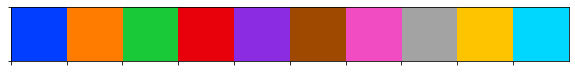

In [45]:
# Save a palette to a variable:
palette = sns.color_palette("bright")
 
# Use palplot and pass in the variable:
sns.palplot(palette)

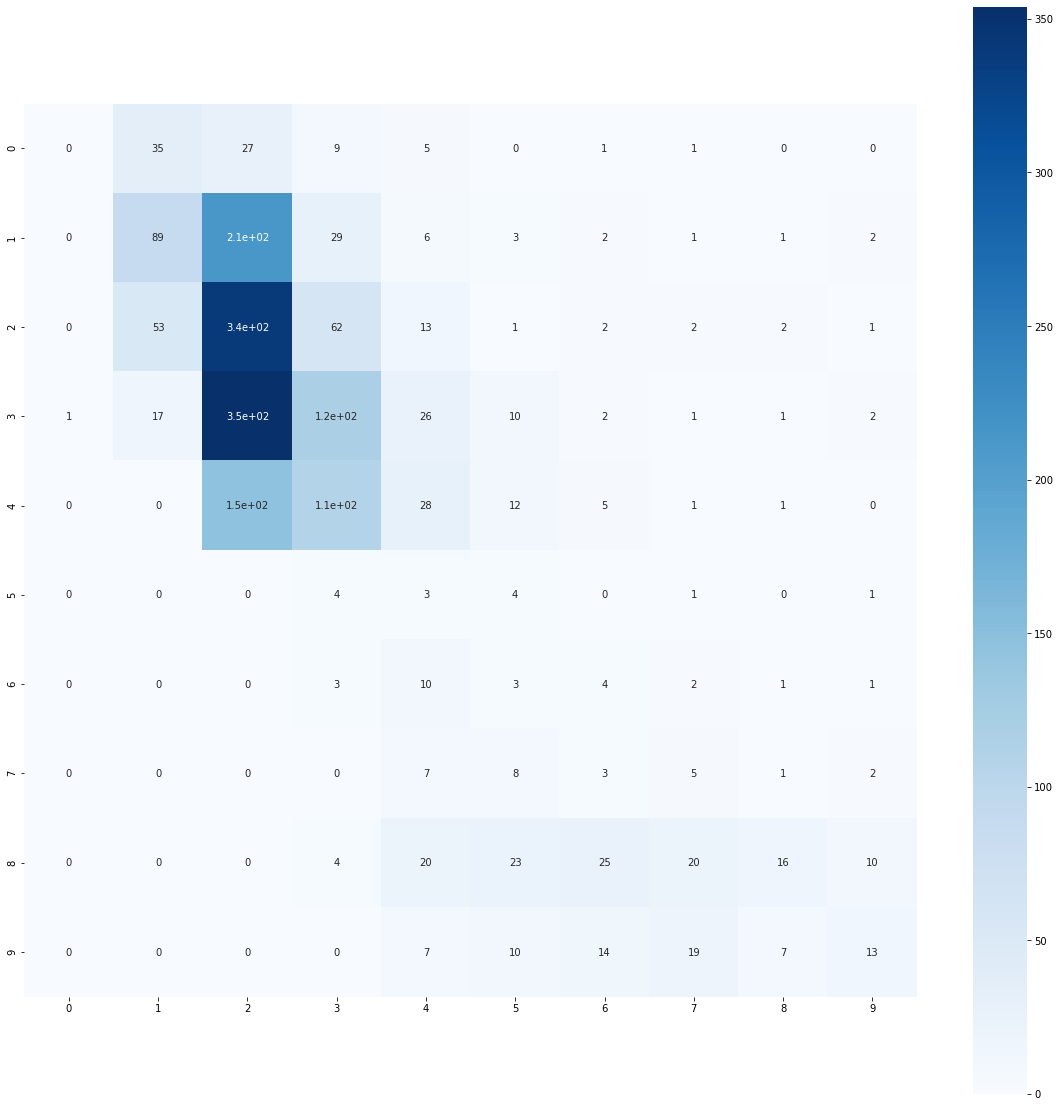

In [64]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
array =cm[0:10,0:10]
df_cm = pd.DataFrame(array)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm,cmap = 'Blues',square=True, annot=True)

In [63]:
cm[0:10,0:10]

array([[  0,  35,  27,   9,   5,   0,   1,   1,   0,   0],
       [  0,  89, 214,  29,   6,   3,   2,   1,   1,   2],
       [  0,  53, 341,  62,  13,   1,   2,   2,   2,   1],
       [  1,  17, 354, 118,  26,  10,   2,   1,   1,   2],
       [  0,   0, 146, 110,  28,  12,   5,   1,   1,   0],
       [  0,   0,   0,   4,   3,   4,   0,   1,   0,   1],
       [  0,   0,   0,   3,  10,   3,   4,   2,   1,   1],
       [  0,   0,   0,   0,   7,   8,   3,   5,   1,   2],
       [  0,   0,   0,   4,  20,  23,  25,  20,  16,  10],
       [  0,   0,   0,   0,   7,  10,  14,  19,   7,  13]])

In [62]:
arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])
print(arr.shape)
print(arr[1:4, 4:1])
# print(arr)

(2, 5)
[]


In [40]:
cm.shape

(52, 52)

Text(0.5, 1.0, 'Fig:1')

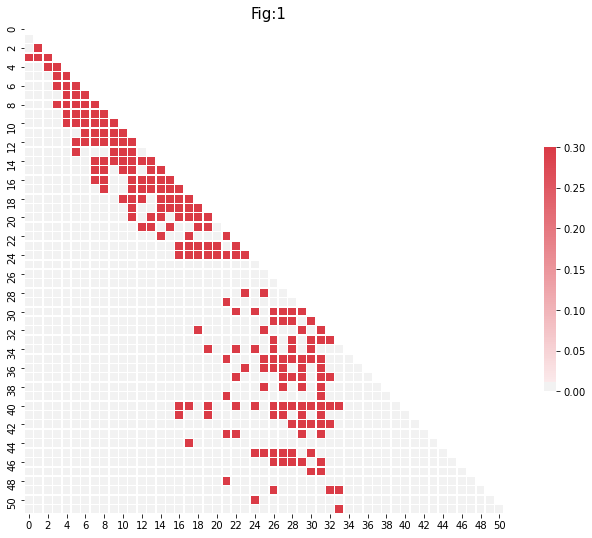

In [44]:
corr = cm

mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Fig:1',size=15)

In [75]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred1, average='macro')

0.052891983273835534

In [68]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred1)

In [70]:
cr

'              precision    recall  f1-score   support\n\n         0.0       0.00      0.00      0.00        79\n         1.0       0.46      0.25      0.33       351\n         2.0       0.32      0.71      0.44       480\n         3.0       0.35      0.22      0.27       532\n         4.0       0.22      0.09      0.13       303\n         5.0       0.05      0.29      0.08        14\n         6.0       0.05      0.13      0.07        30\n         7.0       0.07      0.15      0.10        33\n         8.0       0.33      0.12      0.17       139\n         9.0       0.23      0.15      0.18        85\n        10.0       0.24      0.10      0.14        83\n        11.0       0.03      0.04      0.03        28\n        12.0       0.10      0.10      0.10        20\n        13.0       0.04      0.05      0.05        19\n        14.0       0.06      0.07      0.07        29\n        15.0       0.00      0.00      0.00        13\n        16.0       0.08      0.07      0.08        29\n       

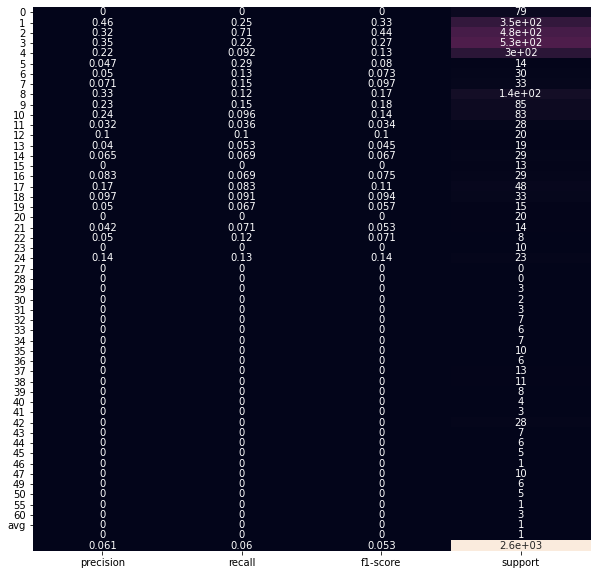

In [67]:
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)

plot_classification_report(y_test, y_pred1)

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()


def main():

    sampleClassificationReport = cr
    plot_classification_report(sampleClassificationReport)
    plt.show()
    plt.close()


if __name__ == '__main__':
    main()

ValueError: could not convert string to float: 'avg'

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,plot_confusion_matrix

In [77]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(n_neighbors=1),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "MultinimialNB": MultinomialNB()
}


In [82]:
trainDataVecs.shape[2]

300

In [81]:
trainDataVecs1 = np.reshape(trainDataVecs,trainDataVecs.shape[0],trainDataVecs.shape[2])
trainDataVecs1.shape

ValueError: cannot reshape array of size 3114300 into shape (10381,)

In [78]:
from sklearn.model_selection import cross_val_score

classifier = KNeighborsClassifier()

classifier.fit(trainDataVecs, y_train)
training_score = cross_val_score(classifier, train_vectors, df_train["domain1_score"], cv=5)
print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

ValueError: Found array with dim 3. Estimator expected <= 2.

In [90]:
np.unique(df['domain1_score'],return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        55, 60]),
 array([ 418, 1736, 2445, 2830, 1424,   96,  137,  163,  737,  383,  372,
         165,  133,   82,  105,   86,  199,  160,  118,   88,  103,   70,
          63,   53,   99,    5,    4,    6,   11,    8,   49,   34,   37,
          32,   39,   47,   65,   39,   20,    8,  161,   22,   23,   15,
          14,   31,   13,    7,    3,    2,   13,    2,    1]))

In [88]:
df

,essay,domain1_score
0,"Dear local newspaper, I think effects computer...",8
1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,"Dear @LOCATION1, I know having computers has a...",8
...,...,...
12971,In most stories mothers and daughters are eit...,35
12972,I never understood the meaning laughter is th...,32
12973,"When you laugh, is @CAPS5 out of habit, or is ...",40
12974,Trippin' on fen...,40


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df['domain1_score']),
                                                 train)